<a href="https://colab.research.google.com/github/RuiQianSun/869/blob/main/Classification_Practice/Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMA 869 Project: Decision Tree Practice

# Inspect and Setup Environment

In [218]:
import pandas as pd
import numpy as np

import itertools
import scipy

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [219]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.6.1.


# Read Data

In [220]:
df = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/resort_train.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6954 entries, 0 to 6953
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GuestID         6954 non-null   int64  
 1   BookingDate     6954 non-null   object 
 2   PromoCode       3709 non-null   object 
 3   Region          6785 non-null   object 
 4   AllInclusive    6786 non-null   float64
 5   Room            6568 non-null   object 
 6   PackageType     6801 non-null   object 
 7   Age             6478 non-null   float64
 8   VIP             6796 non-null   float64
 9   RoomService     6490 non-null   float64
 10  Dining          6466 non-null   float64
 11  Retail          6790 non-null   float64
 12  Spa             6806 non-null   float64
 13  Entertainment   6815 non-null   float64
 14  LoyaltyPoints   6954 non-null   int64  
 15  SurveyScore     6954 non-null   int64  
 16  DaysSinceEmail  6954 non-null   int64  
 17  BookingChannel  6954 non-null   o

,GuestID,BookingDate,PromoCode,Region,AllInclusive,Room,PackageType,Age,VIP,RoomService,...,Retail,Spa,Entertainment,LoyaltyPoints,SurveyScore,DaysSinceEmail,BookingChannel,AgeGroup,ReferralSource,Churned
0,619623,2024-02-10,NaN,Americas,0.0,G/630/S,Relaxation,0.0,0.0,0.0,...,0.0,0.0,0.0,6915,5,136,Website,NaN,Facebook,1
1,776250,2024-01-03,NaN,Americas,1.0,G/201/S,Relaxation,17.0,0.0,0.0,...,0.0,0.0,0.0,8571,5,362,Corporate,Minor,Billboard,1
2,932709,2023-01-17,NaN,Americas,NaN,G/1483/S,Wellness,35.0,0.0,0.0,...,0.0,0.0,0.0,1142,4,154,TravelAgent,Middle,Facebook,0
3,771839,2023-12-09,PromoA,Europe,1.0,D/164/S,Adventure,26.0,0.0,0.0,...,0.0,NaN,0.0,9642,2,128,Website,Young,Magazine,1
4,755501,2024-02-15,PromoA,Americas,0.0,G/818/P,Relaxation,13.0,0.0,0.0,...,60.0,1.0,5147.0,5528,4,35,Mobile,Minor,Google,0


# Simple Feature Engineering and then Decision Tree

In [221]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate

In [222]:
# 1. Pull Numerical Feature Names
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 2. Pull Categorical Feature Names
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Displaying the results to verify
print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")

Numerical Features (13): ['GuestID', 'AllInclusive', 'Age', 'VIP', 'RoomService', 'Dining', 'Retail', 'Spa', 'Entertainment', 'LoyaltyPoints', 'SurveyScore', 'DaysSinceEmail', 'Churned']
Categorical Features (8): ['BookingDate', 'PromoCode', 'Region', 'Room', 'PackageType', 'BookingChannel', 'AgeGroup', 'ReferralSource']


In [223]:
# Scikit-learn needs us to put the features in one dataframe, and the label in another.
# It's tradition to name these variables X and y, but it doesn't really matter.

X = df.drop(['GuestID', 'Churned'], axis=1)
y = df['Churned']

## 1.1: Cleaning and FE for Decision Tree

In [224]:
# We know this dataset has categorical features, and we also know that DTs don't
# allow categorical features. For now, we'll just remove (i.e., drop) these
# features.
#
# TODO: do something better, like encode them (as discussed in the course)

# remove catgorical features
X = X.drop(categorical_features, axis=1, errors='ignore')

# Splitting the data

In [225]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [226]:
# We know this dataset has some missing data, and we also know that DTs don't
# allow missing data. For now, we'll just do simple imputation.
#
# TODO: consider doing something different/better, like impute them (as
# discussed in class)

# replaces missing values with the mean of that feature
imp = SimpleImputer()
imp.fit(X)
X = imp.transform(X)

SimpleImputer()

In [227]:
# Do more data cleaning and FE

## Decision Trees

In [228]:
import numpy as np
# Ensure GuestID is gone
X_train_final = X_train.drop(columns=['GuestID'], errors='ignore')

# Double check the columns before training
print(X_train_final.columns)

# Define feature names for plotting based on the final training features
feature_names_for_tree = X_train_final.columns.tolist()

Index(['AllInclusive', 'Age', 'VIP', 'RoomService', 'Dining', 'Retail', 'Spa',
       'Entertainment', 'LoyaltyPoints', 'SurveyScore', 'DaysSinceEmail'],
      dtype='object')


In [229]:
# Let's create a very simple DecisionTree.
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42, criterion="entropy", min_samples_leaf=10, max_depth=3, max_leaf_nodes=5)

clf.fit(X_train_final, y_train)
y_pred_dt = clf.predict(X_test)
# TODO: Can try different algorithms

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_leaf_nodes=5,
                       min_samples_leaf=10, random_state=42)

In [230]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_dt)

array([[615, 103],
       [285, 388]])

In [231]:
from sklearn.metrics import classification_report
class_names = ['Not Churned', 'Churned']
print(classification_report(y_test, y_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

           0       0.68      0.86      0.76       718
           1       0.79      0.58      0.67       673

    accuracy                           0.72      1391
   macro avg       0.74      0.72      0.71      1391
weighted avg       0.74      0.72      0.71      1391



In [232]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, log_loss

print("Accuracy = {:.2f}".format(accuracy_score(y_test, y_pred_dt)))
print("Kappa = {:.2f}".format(cohen_kappa_score(y_test, y_pred_dt)))
print("F1 Score = {:.2f}".format(f1_score(y_test, y_pred_dt)))
print("Log Loss = {:.2f}".format(log_loss(y_test, y_pred_dt)))


Accuracy = 0.72
Kappa = 0.44
F1 Score = 0.67
Log Loss = 10.05


[Text(0.625, 0.875, 'x[0] <= 0.5\nentropy = 1.0\nsamples = 5563\nvalue = [2734, 2829]'),
 Text(0.5, 0.625, 'x[3] <= 343.0\nentropy = 0.923\nsamples = 3618\nvalue = [2395, 1223]'),
 Text(0.5625, 0.75, 'True  '),
 Text(0.25, 0.375, 'x[6] <= 498.5\nentropy = 0.969\nsamples = 2682\nvalue = [1618, 1064]'),
 Text(0.125, 0.125, 'entropy = 0.997\nsamples = 1981\nvalue = [1050, 931]'),
 Text(0.375, 0.125, 'entropy = 0.701\nsamples = 701\nvalue = [568, 133]'),
 Text(0.75, 0.375, 'x[4] <= 994.5\nentropy = 0.657\nsamples = 936\nvalue = [777, 159]'),
 Text(0.625, 0.125, 'entropy = 0.609\nsamples = 856\nvalue = [728.0, 128.0]'),
 Text(0.875, 0.125, 'entropy = 0.963\nsamples = 80\nvalue = [49, 31]'),
 Text(0.75, 0.625, 'entropy = 0.667\nsamples = 1945\nvalue = [339, 1606]'),
 Text(0.6875, 0.75, '  False')]

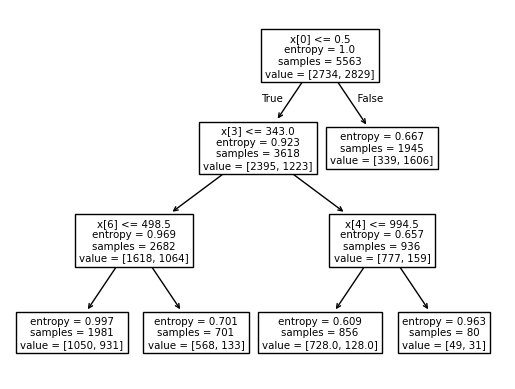

In [233]:
# New in version 0.21. If you don't have 0.21+, then either upgrade, or just skip this cell.
from sklearn import tree
tree.plot_tree(clf)

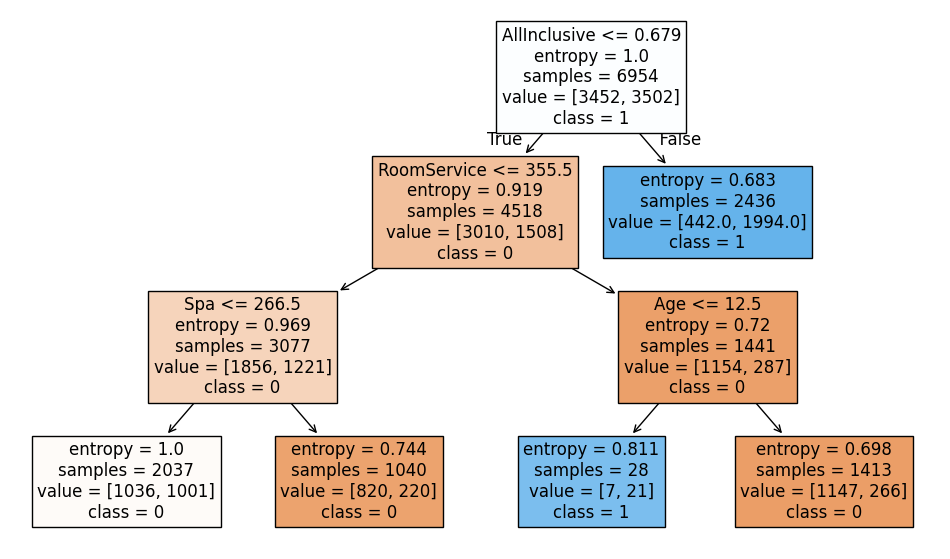

In [237]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7));
tree.plot_tree(clf, filled=True, feature_names=feature_names_for_tree, class_names=class_names, proportion=False, fontsize=12);
#plt.savefig('out/marketing-dt-tree.png', transparent=False);

In [235]:
# Our model's "final form"

clf = clf.fit(X, y)

In [236]:
X_comp = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/resort_test.csv")

# Will need to save these IDs for later
passengerIDs = X_comp["GuestID"]

# Importantly, we need to perform the same cleaning/transformation steps
# on this competition data as you did the training data. Otherwise, we will
# get an error and/or unexpected results.

X_comp = X_comp.drop(['GuestID'], axis=1, errors='ignore')
X_comp = X_comp.drop(categorical_features, axis=1, errors='ignore')

X_comp = imp.transform(X_comp)

# Use your model to make predictions
pred_comp = clf.predict(X_comp)

# Create a simple dataframe with two columns: the passenger ID (just the same as the test data) and our predictions
my_submission = pd.DataFrame({
    'GuestID': passengerIDs,
    'Churned': pred_comp})

# Let's take a peak at the results (as a sanity check)
display(my_submission.head(10))

# You could use any filename.
my_submission.to_csv('submission.csv', index=False)

# You can now download the 'submission.csv' from Colab/Kaggle (see menu on the left or right)

,GuestID,Churned
0,154038,1
1,620160,1
2,655103,0
3,126993,1
4,635228,0
5,844514,1
6,541503,1
7,787572,0
8,645651,0
9,849608,1
